Steps to complete before executing this notebook:

(1) Install needed python libraries: ccdproc, photutils.  To do this, go to a terminal window (Mac) or command line (Windows) and type "conda install ccdproc" (for example).  Repeat with other.

(2) Download data 

(3) Put data in a directory (also known as a Folder) named "raw" and note its full path (also known as address).  For example, my data are saved here: /Users/csalyk/Dropbox/DATA/VASSAR/2018/Apr18/raw on a Mac.  For Windows machines, the format is slightly different, something like "C:\csalyk\Data\raw".

(4) In your parent directory (mine is called Apr18) create a new directory called "overscan_sub" and another new directory called "reduced".

(5) (Optional): Download the FITS image viewer DS9:  https://sites.google.com/cfa.harvard.edu/saoimageds9/download

In [1]:
%pylab inline

import ccdproc as ccdp
from ccdproc import trim_image
from ccdproc import subtract_overscan

import os

from skimage.feature import register_translation

import pickle as pickle

from photutils import DAOStarFinder
from photutils import CircularAperture, CircularAnnulus, aperture_photometry

from astropy.io import fits
from astropy import units as u
from astropy.nddata import CCDData
from astropy.stats import sigma_clipped_stats
from astropy.modeling.models import Gaussian2D

from astropy.visualization import make_lupton_rgb, SqrtStretch, ZScaleInterval

import scipy.ndimage.interpolation as interp

Populating the interactive namespace from numpy and matplotlib


In [2]:
raw_dir='/Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/raw/'
overscan_dir='/Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/overscan_sub/'
reduced_dir='/Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/reduced/'

## Trim flats

Normally, flat frames should have been processed with the same steps as other images, which includes overscan subtraction and trimming.  However, these were not processed entirely correctly, so we will need to trim the flats to the correct size before they can be used. They originally have size 2048 x 2096, and we will trim them to be 2048 x 2048.

First, let's define a function to do the trimming.  It reads in files, trims them to the right size, and then rewrites them out.

In [3]:
def overscan_trim(infiles, outdir):
    if(not outdir.endswith('/')): outdir=outdir+'/'
    if(not os.path.exists(outdir)): os.mkdir(outdir)
    
    #Loop through input images
    for image in infiles:
        outfile=outdir+os.path.split(image)[1]  #Define output file
        print('Processing image '+image)
           
        #Generate a CCDData object from the image's data array
        hdul = fits.open(image)
        ccddata = CCDData(hdul[0].data, unit=u.adu)

        #Trim image
        overscan_subtracted_trimmed_data = np.asarray(trim_image(ccddata[:, :2048]))
            
        #Update header information for image width
        header = hdul[0].header
        header['NAXIS1'] = 2048
        header['IMAGEW'] = 2048
    
        #Save data to outbox directory.
        hdul[0].data = overscan_subtracted_trimmed_data
        hdul.writeto(outfile)

Now, we'll create the list of input images, choose an output directory, and then run the function.

*You will need to replace the directory names with the path to your directories*.

In [4]:
#Create the list of input files
indir='/Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/raw/'  #Replace this!!
filelist=[]
for file in os.listdir(indir):
    if (file.endswith("FLAT.fit")): #Find all FLAT files
        filelist.append(os.path.join(indir, file))

#Define the output directory  
outdir='/Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/overscan_sub/'   #Replace this!!
print(filelist)  #Run this command to check your list of files

['/Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/raw/RFLAT.fit', '/Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/raw/BFLAT.fit', '/Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/raw/VFLAT.fit']


In [6]:
#Trim all images in the filelist
overscan_trim(filelist, outdir)

Processing image /Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/raw/RFLAT.fit
Processing image /Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/raw/BFLAT.fit
Processing image /Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/raw/VFLAT.fit


After this step, you can check the overscan_sub directory to make sure the images are there.

## Perform overscan subtraction

First, let's define a function to perform overscan subtraction and trimming of all images.

In [7]:
def overscan_subtraction(infiles, outdir):
    if(not outdir.endswith('/')): outdir=outdir+'/'
    if(not os.path.exists(outdir)): os.mkdir(outdir)
    
    #Scan inbox directory for .fit files
    for image in infiles:
        outfile=outdir+os.path.split(image)[1]  #Define output file
        print('Processing image '+image)
           
        #Generate a CCDData object from the image's data array
        hdul = fits.open(image)
        ccddata = CCDData(hdul[0].data, unit=u.adu)

        #subtract overscan row-by-row and crop region
        overscan_subtracted_data = subtract_overscan(ccddata, overscan=ccddata[:, 2049:2096])
        overscan_subtracted_trimmed_data = np.asarray(trim_image(overscan_subtracted_data[:, :2048]))
            
        #Update header information for image width
        header = hdul[0].header
        header['NAXIS1'] = 2048
        header['IMAGEW'] = 2048
    
        #Save data to outbox directory.
        hdul[0].data = overscan_subtracted_trimmed_data
        hdul.writeto(outfile)

Just as before, we need to define our input files, and our output directory.  

*You will need to change these directories to match your paths.*

In [8]:
#Create the list of input files
indir='/Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/raw/'  #Replace this!!
filelist=[]
for file in os.listdir(indir):
    if(file.endswith("b.fit") or file.endswith("d.fit") or file.endswith("r.fit") or
       file.endswith("v.fit") or file.endswith("z.fit") ): #Find all files *except* FLAT files
           filelist.append(os.path.join(indir, file))

#Define the output directory  
outdir='/Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/overscan_sub/'   #Replace this!!
print('output directory:', outdir)
#print(filelist)  #Run this command to check your list of files

output directory: /Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/overscan_sub/


Then use the function we defined to do overscan subtraction on all images.

In [9]:
#Run overscan subtraction on filelist
overscan_subtraction(filelist, outdir)

Processing image /Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/raw/18p18-003b.fit
Processing image /Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/raw/18p18-002testr.fit
Processing image /Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/raw/18p18-002r.fit
Processing image /Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/raw/18p18-003v.fit
Processing image /Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/raw/18p18-002d.fit
Processing image /Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/raw/18p18-003d.fit
Processing image /Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/raw/18p18-001z.fit
Processing image /Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/raw/18p18-003r.fit
Processing image /Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/raw/18p18-002v.fit
Processing image /Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/raw/18p18-002b.fit
Processing image /Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/raw/18p18-005v.fit
Processing image /Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/raw/18p18-004r.fit
Processing i

Do a visual inspection to make sure the routine worked as expected, and that your overscan-subtrated image has the correct size (2048 x 2048).

*You will need to replace the presub and postsub file names with your file names!*

Shapes of images:  (2048, 2096) (2048, 2048)
Mean values in images: 1624.7094617071953 138.52704117653235


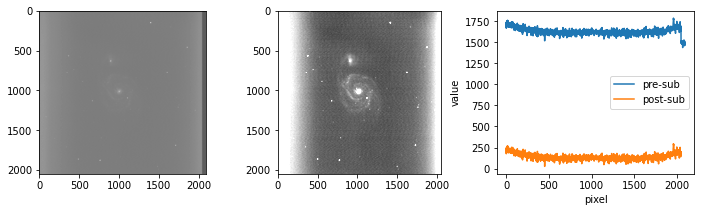

In [10]:
presub_file='/Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/raw/18p18-001v.fit' #Replace!!
postsub_file='/Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/overscan_sub/18p18-001v.fit' #Replace!!
presub_hdul = fits.open(presub_file)   #Read in pre-subtraction image
postsub_hdul = fits.open(postsub_file) #Read in post-subtraction image
presub_img = presub_hdul[0].data
postsub_img = postsub_hdul[0].data

fig=plt.figure(figsize=(12,3))
#Plot pre-sub image
ax1=fig.add_subplot(131)
ax1.imshow(presub_img, cmap='gray',vmin=np.median(presub_img)*0.7, vmax=np.median(presub_img)*1.3)
#Plot post-sub image
ax2=fig.add_subplot(132)
ax2.imshow(postsub_img, cmap='gray',vmin=np.median(postsub_img)*0.7, vmax=np.median(postsub_img)*1.3)
#Plot one row of each image, to compare
ax3=fig.add_subplot(133)
ax3.plot(presub_img[1250,:],label='pre-sub')
ax3.plot(postsub_img[1250,:],label='post-sub')
ax3.legend()
ax3.set_xlabel('pixel')
ax3.set_ylabel('value')

print('Shapes of images: ',np.shape(presub_img),np.shape(postsub_img))
print('Mean values in images:', np.mean(presub_img),np.mean(postsub_img))

## Create a master bias

Collect bias frames and produce an average 'master' bias.  

*You will need to replace the overscan_path with your directory!*

In [11]:
#Define the path to the overscan-subtracted bias images
overscan_path = '/Users/cosalyk/Dropbox/DATA/VASSAR/2018/apr18/overscan_sub/' #Replace!
#Define the list of bias images
overscan_biases = ccdp.ImageFileCollection(overscan_path,glob_include='*z.fit') #z.fit refers to bias images
#Print out basic info about images to make sure you got the right ones
print(overscan_biases.summary['file', 'imagetyp', 'exptime', 'naxis1', 'naxis2'])
overscan_bias_files = overscan_biases.files_filtered(include_path=True)
#Combine bias frames together by averaging. Save to "master_bias.fit"
combined_bias = ccdp.combine(overscan_bias_files, unit='adu',
                             output_file=overscan_path+'master_bias.fit',overwrite=True)

     file       imagetyp  exptime naxis1 naxis2
-------------- ---------- ------- ------ ------
18p18-001z.fit Bias Frame     0.0   2048   2048
18p18-002z.fit Bias Frame     0.0   2048   2048
18p18-003z.fit Bias Frame     0.0   2048   2048


Inspect master bias

*You will need to replace the file name with your file name!*

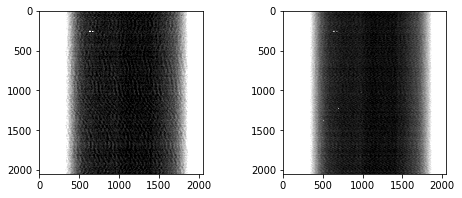

In [12]:
masterbias_file='/Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/overscan_sub/master_bias.fit' #Replace!
masterbias_hdul = fits.open(masterbias_file)   #Read in bias image
masterbias_img = masterbias_hdul[0].data

bias_hdul = fits.open(overscan_bias_files[0])
bias_img = bias_hdul[0].data

fig=plt.figure(figsize=(8,3))
#Plot bias image
ax1=fig.add_subplot(121)
ax1.imshow(bias_img, cmap='gray',vmin=np.median(bias_img)*0.7, vmax=np.median(bias_img)*1.3)
ax2=fig.add_subplot(122)
ax2.imshow(masterbias_img, cmap='gray',vmin=np.median(bias_img)*0.7, vmax=np.median(bias_img)*1.3)

## Create a master dark

First inspect exposure times to decide on strategy.

Option 1: Average all dark frames with same exposure time as science frames.

Option 2: Subtract bias from all dark frames, then scale by exposure time for each science frame.

In the window below, re-run with appropriate endings for your science and dark frames, to see what their respective exposure times are.

In [5]:
overscan_dir='/Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/overscan_sub/'  #Replace!
#Inspect all images to look at exposure times of science and dark frames
all_images = ccdp.ImageFileCollection(overscan_dir,glob_include='*b.fit')  #Modify and re-run
#all_images.summary['file','imagetyp','exptime'].show_in_notebook()
#Dark frames all had 60 second exposure.
#Most science frames had 60 second exposures, while some had other exposure times.
#I'm going with option 1

Now run this code to collect all 60s darks and make a master dark.

In [14]:
dark_images=ccdp.ImageFileCollection(overscan_dir,glob_include='*d.fit')
dark_60s_files = dark_images.files_filtered(exptime=60.0,include_path=True)
combined_dark_60s = ccdp.combine(dark_60s_files, unit='adu',
                             output_file=overscan_dir+'master_dark_60s.fit')

## Create a master flat

In our case, our flats are already constructed.  Let's inspect the flat to make sure it's reasonable.  Look carefully to see dust "donuts".

*You will need to change the directory name, and also look at all 3 flats by replacing the file name*.

(2048, 2048)


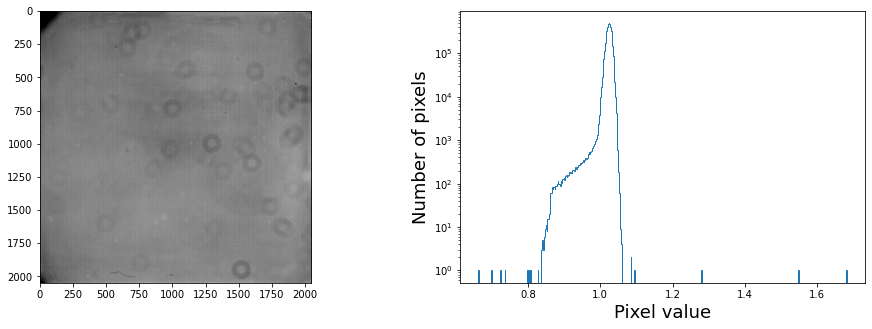

In [16]:
data_dir='/Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/overscan_sub/'
flat_file=data_dir+'VFLAT.fit'  #Look at all 3 by replacing this name with BFLAT, RFLAT
flat_hdul = fits.open(flat_file)   #Read in pre-subtraction image
flat_img = flat_hdul[0].data
#B and R both look really strange.  I and V look okay.

fig=plt.figure(figsize=(16,5))
#Plot image
ax1=fig.add_subplot(121)
ax1.imshow(flat_img, cmap='gray',vmin=np.median(flat_img)*0.95, vmax=np.median(flat_img)*1.05)

ax2=fig.add_subplot(122)
ax2.hist(flat_img.flatten(),histtype='step',bins=500)
ax2.set_yscale('log')
ax2.set_xlabel('Pixel value',fontsize=18)
ax2.set_ylabel('Number of pixels',fontsize=18)

#Print out shape of image to make sure it's been overscan-subtracted
print(np.shape(flat_img))

## "Reduce" data files (perform bias and dark subtraction, division by flat)

Let's do one image to test the procedure

In [17]:
#First, select all V-filter images with 60s exposure times.
science_ifc=ccdp.ImageFileCollection(overscan_dir,glob_include='*b.fit')
science_files = science_ifc.files_filtered(include_path=True,exptime=60.0)
science_ccd1=CCDData.read(science_files[0], unit="adu") 

master_dark_60s_ccd=CCDData.read(overscan_dir+'master_dark_60s.fit', unit="adu")

flat_ccd=CCDData.read(overscan_dir+'BFLAT.fit', unit="adu")

#Subtract the dark from the science image
reduced_ccd1 = ccdp.subtract_dark(science_ccd1, master_dark_60s_ccd,
                              exposure_time='EXPTIME', #Name of exposure time in header
                              exposure_unit=u.second)

#Divide the dark-subtracted science image by the flat
reduced_ccd1 = ccdp.flat_correct(reduced_ccd1, flat_ccd)

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


Now output the resulting image, to make sure it's sensible, and to check that the reduced image is improved over the raw image.

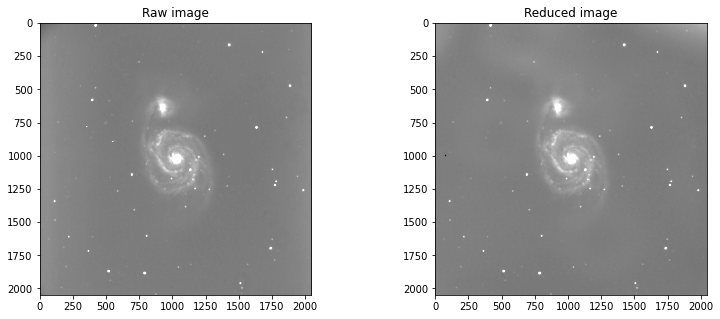

In [18]:
fig=plt.figure(figsize=(13,5))
#Plot image
ax1=fig.add_subplot(121)
ax1.set_title('Raw image')
ax1.imshow(science_ccd1.data, cmap='gray',vmin=np.median(science_ccd1.data)*0.5, 
           vmax=np.median(science_ccd1.data)*1.5)

ax2=fig.add_subplot(122)
ax2.set_title('Reduced image')
ax2.imshow(reduced_ccd1.data, cmap='gray',vmin=np.median(reduced_ccd1.data)*0.5, 
           vmax=np.median(reduced_ccd1.data)*1.5)

Now we'll turn this into a loop over all images

In [19]:
def data_reduction_loop(science_files, master_dark_file, master_flat_file, overscan_dir, reduced_dir):

    master_dark_ccd=CCDData.read(overscan_dir+master_dark_file, unit="adu")
    flat_ccd=CCDData.read(overscan_dir+master_flat_file, unit="adu")
    
    for i, myfile in enumerate(science_files):
        science_ccd=CCDData.read(overscan_dir+myfile, unit="adu") 
 
    #Subtract the dark from the science image
        reduced_ccd = ccdp.subtract_dark(science_ccd, master_dark_ccd,
                                      exposure_time='EXPTIME', #Name of exposure time in header
                                      exposure_unit=u.second)

    #Divide the dark-subtracted science image by the flat
        reduced_ccd = ccdp.flat_correct(reduced_ccd, flat_ccd)

    #Write file out
        outfile=reduced_dir+myfile
        print("Writing reduced image data to:",outfile)
        reduced_ccd.write(outfile)

Now run the loop, once for each color of image.  

*You will need to replace the directory names below!*

In [20]:
#Define data directories
overscan_dir='/Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/overscan_sub/'
reduced_dir='/Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/reduced/'

#Define master dark and master flat images
master_dark_file='master_dark_60s.fit'

#Define flat. Define list of science images from overscan. Run loop.
master_flat_file='VFLAT.fit'
science_ifc=ccdp.ImageFileCollection(overscan_dir,glob_include='*v.fit')
science_files = science_ifc.files_filtered(exptime=60.0)
data_reduction_loop(science_files, master_dark_file, master_flat_file, overscan_dir, reduced_dir)

#Define flat. Define list of science images from overscan. Run loop.
master_flat_file='RFLAT.fit'
science_ifc=ccdp.ImageFileCollection(overscan_dir,glob_include='*r.fit')
science_files = science_ifc.files_filtered(exptime=60.0)
data_reduction_loop(science_files, master_dark_file, master_flat_file, overscan_dir, reduced_dir)

#Define flat. Define list of science images from overscan. Run loop.
master_flat_file='BFLAT.fit'
science_ifc=ccdp.ImageFileCollection(overscan_dir,glob_include='*b.fit')
science_files = science_ifc.files_filtered(exptime=60.0)
data_reduction_loop(science_files, master_dark_file, master_flat_file, overscan_dir, reduced_dir)

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Writing reduced image data to: /Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/reduced/18p18-006v.fit
Writing reduced image data to: /Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/reduced/18p18-007v.fit
Writing reduced image data to: /Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/reduced/18p18-008v.fit
Writing reduced image data to: /Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/reduced/18p18-009v.fit
Writing reduced image data to: /Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/reduced/18p18-010v.fit


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Writing reduced image data to: /Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/reduced/18p18-001testr.fit


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Writing reduced image data to: /Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/reduced/18p18-001b.fit
Writing reduced image data to: /Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/reduced/18p18-002b.fit
Writing reduced image data to: /Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/reduced/18p18-003b.fit
Writing reduced image data to: /Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/reduced/18p18-004b.fit
Writing reduced image data to: /Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/reduced/18p18-005b.fit


## Compute image shifts, align images, and add together for each filter

Define a simple function to compute image shifts. This code uses the "register_translation" function.

In [21]:
def compute_image_shifts(science_files, reduced_dir, output_file, ref_file=None,plot=True,ref_pos=None):
    if(ref_file is None): 
        ref_file=science_files[0]
    ## choose an image to define as zero shift:
    science_ccd1=CCDData.read(reduced_dir+ref_file, unit="adu") 
    zero_shift_data = science_ccd1.data
    imshifts = {} # dictionary to hold the x and y shift pairs for each image

    for i, myfile in enumerate(science_files):
        science_ccd=CCDData.read(reduced_dir+myfile, unit="adu") 
        data=science_ccd.data
    ## register_translation is a function that calculates shifts by comparing 2-D arrays
        result, error, diffphase = register_translation(zero_shift_data, data, 1000)
        imshifts[myfile] = result
        if(ref_pos is not None):
            fig=plt.figure()
            ax1=fig.add_subplot(111)
            ax1.imshow(data,cmap='Greys',vmin=np.median(data)*0.5, 
               vmax=np.median(data)*1.5)
            print(result)
            ax1.plot(ref_pos[0]-result[1],ref_pos[1]-result[0], 'r+',markersize=20)
            ax1.set_xlim(900,1100)
            ax1.set_ylim(900,1100)
            plt.show()
    pickle.dump( imshifts, open(reduced_dir+output_file, "wb" ))  #Write image shifts to file

Now define list of images and name of image shift output file. Then run loop.  **Warning!!** This code takes several minutes and may use a lot of processor power.  Don't run this code unless you're sure you want to.

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
[0. 0.]


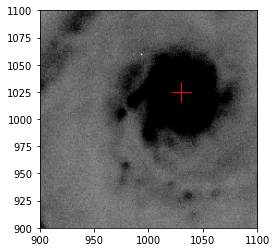

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
[-0.001 -0.001]


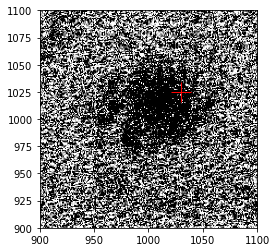

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
[1.088 0.999]


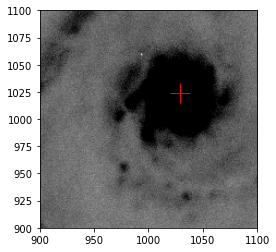

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
[1.57  3.782]


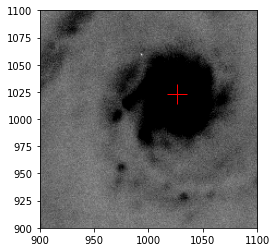

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
[1.503 5.864]


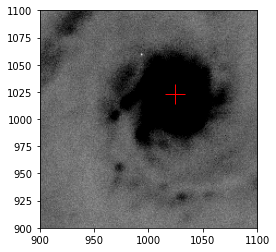

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
[2.434 6.623]


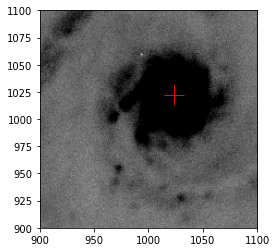

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
[ 6.954 25.869]


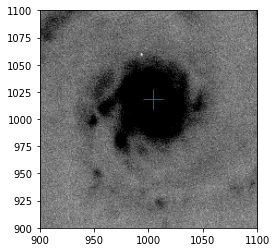

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
[ 8.333 26.829]


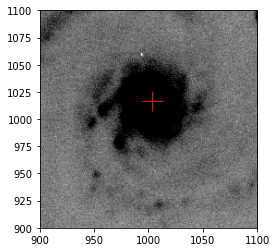

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
[ 8.559 28.684]


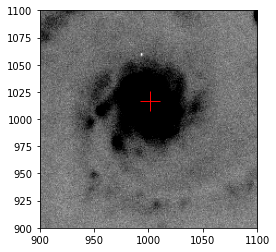

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
[ 8.831 30.498]


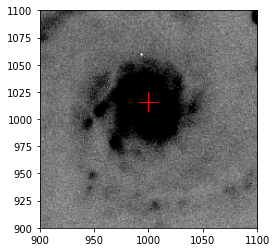

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
[ 9.161 32.464]


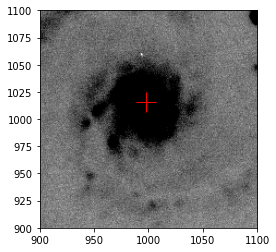

In [22]:
#Read in all files in *reduced* image directory
reduced_dir='/Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/reduced/'
science_ifc=ccdp.ImageFileCollection(reduced_dir,glob_include='*.fit')
science_files = science_ifc.files_filtered()
output_file='image_shifts.p'

compute_image_shifts(science_files, reduced_dir, output_file, ref_pos=np.array([1030,1025])) #Comment this out if you don't want to run it accidentally.

To check shifts, I'll show all images with positions of shifted stars.  First, I'll write a program to do this.

In [23]:
def show_image_shifts(science_files, reduced_dir, shift_file='image_shifts.p',ref_pos=None):
    ## choose an image to define as zero shift:
    imshifts = pickle.load(open(reduced_dir+shift_file, "rb" )) # dictionary to hold the x and y shift pairs for each image

    for i, myfile in enumerate(science_files):
        science_ccd=CCDData.read(reduced_dir+myfile, unit="adu") 
        data=science_ccd.data
    ## register_translation is a function that calculates shifts by comparing 2-D arrays
        result=imshifts[myfile]
        if(ref_pos is not None):
            fig=plt.figure()
            ax1=fig.add_subplot(111)
            ax1.imshow(data,cmap='Greys',vmin=np.median(data)*0.5, 
               vmax=np.median(data)*1.5)
            print(result)
            ax1.plot(ref_pos[0]-result[1],ref_pos[1]-result[0], 'r+',markersize=20)
            ax1.set_xlim(900,1100)
            ax1.set_ylim(900,1100)
            plt.show()

I found that the r image wasn't shifted correctly, so I manually changed it.

In [24]:
image_shift_file="image_shifts.p"
out=pickle.load(open(reduced_dir+"image_shifts.p", 'rb'))
out['18p18-001testr.fit']=np.array([10,19])
pickle.dump(out, open(reduced_dir+"image_shifts.p", 'wb'))

Now I'll run my 'show_image_shifts' routine to make sure the shifts look good.

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
[0. 0.]


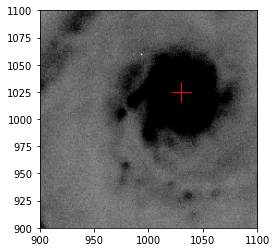

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
[10 19]


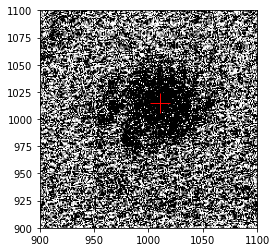

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
[1.088 0.999]


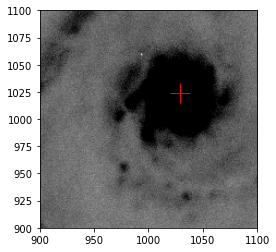

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
[1.57  3.782]


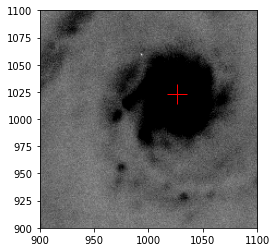

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
[1.503 5.864]


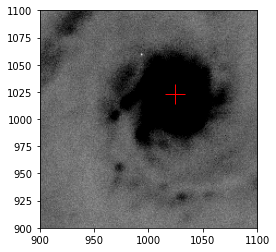

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
[2.434 6.623]


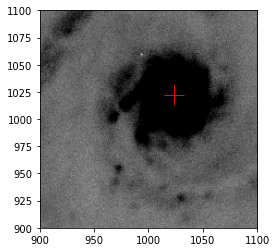

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
[ 6.954 25.869]


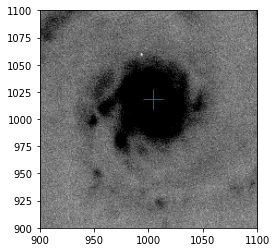

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
[ 8.333 26.829]


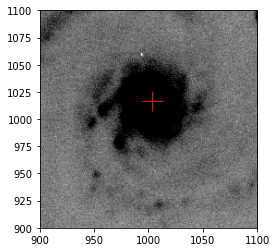

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
[ 8.559 28.684]


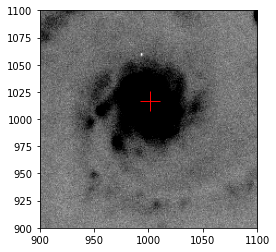

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
[ 8.831 30.498]


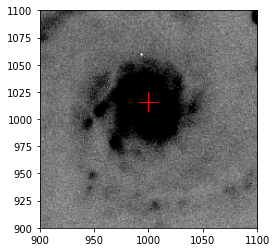

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
[ 9.161 32.464]


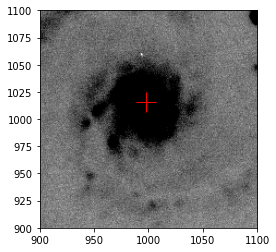

In [25]:
#Read in all files in *reduced* image directory
reduced_dir='/Users/cosalyk/Dropbox/DATA/VASSAR/2018/Apr18/reduced/'
science_ifc=ccdp.ImageFileCollection(reduced_dir,glob_include='*.fit')
science_files = science_ifc.files_filtered()
output_file='image_shifts.p'

show_image_shifts(science_files, reduced_dir, ref_pos=np.array([1030,1025])) 

Write a function to shift and average a set of images. Outputs an array.

In [26]:
def shift_average(unshifted_images,reduced_dir, image_shift_file):
#Read in image shifts
    image_shifts=pickle.load( open( reduced_dir+image_shift_file, "rb" ) )

#Loop through all images and create shifted data
    shifted_data=[]
    for myimage in unshifted_images:
        hdul = fits.open(reduced_dir+myimage)
        data = hdul[0].data
        shifted_data.append(interp.shift(data,image_shifts[myimage]))
## array of aligned arrays: 
    image_cube  = np.stack(shifted_data,axis=0)

## average combined final image: 
    image_stacked = np.average(image_cube, axis=0)

    return image_stacked

Use the function to make stacked versions of the v, b and r images.

In [27]:
science_ifc=ccdp.ImageFileCollection(reduced_dir,glob_include='*v.fit')
science_files = science_ifc.files_filtered()
stacked_image_v=shift_average(science_files,reduced_dir, image_shift_file)

science_ifc=ccdp.ImageFileCollection(reduced_dir,glob_include='*b.fit')
science_files = science_ifc.files_filtered()
stacked_image_b=shift_average(science_files,reduced_dir, image_shift_file)

science_ifc=ccdp.ImageFileCollection(reduced_dir,glob_include='*r.fit')
science_files = science_ifc.files_filtered()
stacked_image_r=shift_average(science_files,reduced_dir, image_shift_file)

Plot the result to make sure it looks okay.

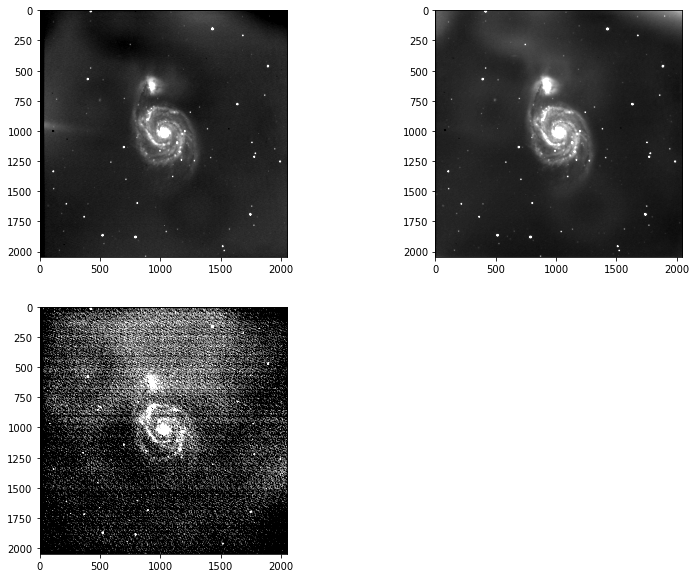

In [28]:
fig=plt.figure(figsize=(13,10))
#Plot image
ax1=fig.add_subplot(221)
ax1.imshow(stacked_image_v, cmap='gray',vmin=np.median(stacked_image_v)*0.95, vmax=np.median(stacked_image_v)*1.3)

ax2=fig.add_subplot(222)
ax2.imshow(stacked_image_b, cmap='gray',vmin=np.median(stacked_image_b)*0.95, vmax=np.median(stacked_image_b)*1.3)

ax3=fig.add_subplot(223)
ax3.imshow(stacked_image_r, cmap='gray',vmin=np.median(stacked_image_r)*0.95, vmax=np.median(stacked_image_r)*1.3)

Now, I'll 'stretch' each image, and combine them into an RGB image.

In [29]:
stretch = ZScaleInterval()
image_r=stretch(stacked_image_r)
image_g=stretch(stacked_image_v)
image_b=stretch(stacked_image_b)
color_image=np.zeros([2048,2048,3])
color_image[:,:,0]=image_r
color_image[:,:,1]=image_g
color_image[:,:,2]=image_b

*At this point, you'll probably want to play with the stretch to see if you can improve your image!*  Read more about it here:
http://docs.astropy.org/en/stable/visualization/normalization.html#intervals-and-normalization

Plot the result!

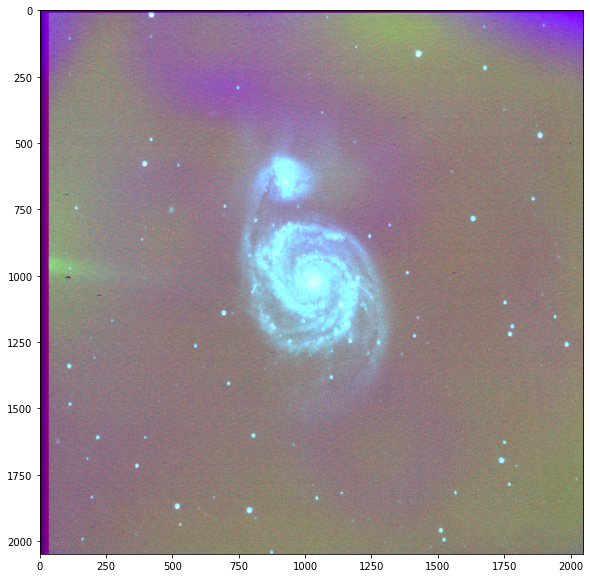

In [30]:
fig=plt.figure(figsize=(10,10))
#Plot image
ax1=fig.add_subplot(111)
ax1.imshow(color_image)